In [1]:
## Imports and setting up GDAL environment variables
import os, sys
import requests as rq
import json

import logging

import geopandas as gpd

import numpy as np

from PIL import Image

import shapely
import shapely.wkt
from shapely.ops import transform as shapely_transform
from shapely.geometry import shape, MultiPolygon

import pyproj
from pyproj import Proj

import rasterio as rio
from rasterio.mask import mask

import folium
from folium import plugins

/home/enceladus/.local/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.0-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
# setting env variables
os.environ['GDAL_HTTP_COOKIEFILE'] = '~/cookies.txt'
os.environ['GDAL_HTTP_COOKIEJAR'] = '~/cookies.txt'
os.environ['GDAL_DISABLE_READDIR_ON_OPEN'] = 'YES'
os.environ['CPL_VSIL_CURL_ALLOWED_EXTENSIONS'] ='TIF'
np.seterr(divide='ignore', invalid='ignore')

gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

logger = logging.getLogger(__name__)
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

In [5]:
# functions

def add_geojson_to_map(geojson, map):
    folium.GeoJson(geojson['geometry'],
        name = geojson['properties']['id'],
        zoom_on_click=True,
        style_function=styles).add_to(map)

def add_array_to_map(array,bounds,name):
    folium.raster_layers.ImageOverlay(
        image=array,
        name=name,
        opacity=1,
        bounds= boundary
    ).add_to(m)

In [6]:
# keeping a dictionary of custom base maps for folium
basemaps = {
    'Google Maps': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Maps',
        overlay = True,
        control = True
    ),
    'Google Satellite': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Google Terrain': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=p&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Terrain',
        overlay = True,
        control = True
    ),
    'Google Satellite Hybrid': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    )
}


styles =lambda feature: {
        "fillColor": "blue",
        "color": "white",
        "weight": 2,
        "dashArray": "5, 5"}

In [7]:
# Reading given KML files, and appending them to one dataframe

k15_df = gpd.read_file('k15.kml', driver='KML')
k26_df = gpd.read_file('k26.kml', driver='KML')

kml_df = k15_df.append(k26_df)

kml_df

,Name,Description,geometry
0,Polygon-0,"20,101 m²; 572.07 m","POLYGON Z ((73.79214 20.26259 1.00000, 73.7935..."
0,Polygon-0,"33,719 m²; 821.16 m","POLYGON Z ((73.79626 20.26437 1.00000, 73.7953..."


In [8]:
# getting bounding coords of both farms

outer_bounds = kml_df.total_bounds.tolist()
outer_bounds

[73.79177536815405, 20.26102455776828, 73.79627712070942, 20.26463721675329]

## using STAC endpoint of Sentinel 2 to get requried images

In [9]:
from pystac_client import Client

catalog = Client.open("https://earth-search.aws.element84.com/v0")


mysearch = catalog.search(
    collections=['sentinel-s2-l2a-cogs'], 
    bbox= outer_bounds, 
    datetime="2019-09-01/2020-03-30")
print(f"{mysearch.matched()} items found")

43 items found


In [10]:
import stackstac

In [11]:
## using stackstac to create a Dask Xarray from STAC metadata

%time
stack = stackstac.stack(mysearch.items_as_collection(),bounds_latlon=outer_bounds)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 2.86 µs


In [12]:
stack

,Array,Chunk
Bytes,10.98 MiB,15.38 kiB
Shape,"(43, 17, 41, 48)","(1, 1, 41, 48)"
Count,2194 Tasks,731 Chunks
Type,float64,numpy.ndarray


In [13]:
#filtering thru the dataset for required bands and cloud cover, and making required Indices

lowcloud = stack[stack["eo:cloud_cover"] < 20]

nir, red, swir = lowcloud.sel(band="B08"), lowcloud.sel(band="B04"), lowcloud.sel(band="B11")

ndvi = (nir - red) / (nir + red)
ndmi = (nir - swir) / (nir + swir)

## Using Dask for computation, makes large area/long time series calculations faster

In [14]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(memory_limit='1GB')
client = Client(cluster)

In [16]:
client

Client Scheduler: tcp://127.0.0.1:41629 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 3.73 GiB


In [17]:
monthly_ndvi = ndvi.resample(time="M").mean(dim="time")

In [18]:
monthly_ndmi = ndmi.resample(time="M").mean(dim="time")

In [19]:
m_ndmi = monthly_ndmi.compute()

In [20]:
m_ndmi.shape

(6, 41, 48)

In [21]:
m_ndvi = monthly_ndvi.compute()

In [22]:
m_ndvi.shape

(6, 41, 48)

In [23]:
import matplotlib.pyplot as plt

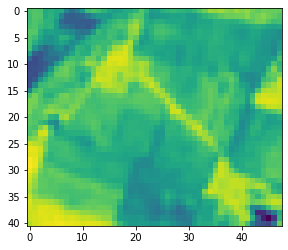

In [24]:
plt.imshow(m_ndvi[0])

### adding metadata to Xarray to write better geotiffs

In [25]:
import rioxarray

In [26]:
m_ndmi.attrs['nodata'] = np.nan
m_ndvi.attrs['nodata'] = np.nan

m_ndmi.attrs['crs'] = m_ndmi.rio.crs
m_ndvi.attrs['crs'] = m_ndvi.rio.crs

In [27]:
m_ndvi.rio.to_raster('monthly_ndvi.tif')

In [28]:
m_ndmi.rio.to_raster('monthly_ndmi.tif')

## Prepping for PNG creation

In [29]:
## reseting index to get correct index numbering

kmldf = kml_df.reset_index()
del kmldf['index']

In [30]:
# converting KML WGS84 coords to UTM zone of image

kmldf_utm = kmldf.to_crs("EPSG:"+str(m_ndvi.epsg.values.tolist()))


#simplifying the output to make clipping neater

kml_sim = kmldf_utm.simplify(tolerance=0.5,preserve_topology=False)


# converting to geojson for use in rasterio

geoj = json.loads(kml_sim.geometry.to_json())

In [31]:
ndvi_ds = rio.open('monthly_ndvi.tif')
ndmi_ds = rio.open('monthly_ndmi.tif')

In [32]:
month_lookup = {'0':'2019_10','1':'2019_11','2':'2019_12','3':'2020_01','4':'2020_02','5':'2020_03'}
farm_loookup = {'0':'farm_15','1':'farm_26'}

In [33]:
if not os.path.exists('./farm_15/'):
    os.makedirs('./farm_15/')

if not os.path.exists('./farm_26/'):
    os.makedirs('./farm_26/')

In [34]:
kwargs = ndvi_ds.profile
kwargs['count'] = 1
kwargs['nodata'] = 0
kwargs['driver'] = 'PNG'
kwargs['dtype'] = 'uint8'
del kwargs['crs']
del kwargs['transform']
del kwargs['tiled']
del kwargs['interleave']

In [35]:
kwargs

{'driver': 'PNG', 'dtype': 'uint8', 'nodata': 0, 'width': 48, 'height': 41, 'count': 1}

## Creating Colored PNGs for output for both Vegetation and Water stress

### The calculation for Vegetation stress is done using the median NDVI value of a month, and highlighting all pixels that lower than "median - 10% median"

### The calculation for Water stress is done using the median NDMI value of a month, and highlighting all pixels that lower than "median - 60% median"

In [36]:
for x in range(len(geoj['features'])):
    ndvi_clip, _ = mask(ndvi_ds,[geoj['features'][x]['geometry']],crop=True)
    ndmi_clip, _ = mask(ndmi_ds,[geoj['features'][x]['geometry']],crop=True)
    
    for i in range(ndvi_clip.shape[0]):
        
        ndvi_stress = np.where(ndvi_clip[i] < np.nanmedian(ndvi_clip[i])-(0.1*np.nanmedian(ndvi_clip[i])),1,0)
        
        with rio.open(f'./{farm_loookup[str(x)]}/ndvi_stress_{month_lookup[str(i)]}.png', 'w', **kwargs) as d:
            d.write(ndvi_stress,1)
        
        os.system(f"gdaldem color-relief -alpha './{farm_loookup[str(x)]}/ndvi_stress_{month_lookup[str(i)]}.png' ./color_ndvi.txt './{farm_loookup[str(x)]}/ndvi_stress_{month_lookup[str(i)]}_color.png'")

        if np.nanmedian(ndmi_clip[i]) > 0:
            ndmi_stress = np.where(ndmi_clip[i] < np.nanmedian(ndmi_clip[i])-(0.6*np.nanmedian(ndmi_clip[i])),1,0)
        else:
            ndmi_stress = np.where(ndmi_clip[i] < np.nanmedian(ndmi_clip[i])+(0.6*np.nanmedian(ndmi_clip[i])),1,0)
        
        with rio.open(f'./{farm_loookup[str(x)]}/ndmi_stress_{month_lookup[str(i)]}.png', 'w', **kwargs) as d:
            d.write(ndmi_stress,1)
        
        os.system(f"gdaldem color-relief -alpha './{farm_loookup[str(x)]}/ndmi_stress_{month_lookup[str(i)]}.png' ./color_ndmi.txt './{farm_loookup[str(x)]}/ndmi_stress_{month_lookup[str(i)]}_color.png'")

/home/enceladus/.local/lib/python3.8/site-packages/rasterio/__init__.py:230: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = writer(path, mode, driver=driver,


## Finally, visualizing Farm monthly health

In [37]:
import glob

m = folium.Map(location=[kmldf.centroid.y[0],kmldf.centroid.x[0]], tiles='Stamen Terrain', zoom_start=15)

for x in range(len(geoj['features'])):
    
    bottom, left, top, right = kmldf.bounds.minx[x], kmldf.bounds.miny[x], kmldf.bounds.maxx[x], kmldf.bounds.maxy[x]
    
    boundary = [[left, bottom],[right, top]]
    
    pngs = sorted(glob.glob(f'./{farm_loookup[str(x)]}/*color.png'))
    
    for png in pngs:
        
        png_array = np.array(Image.open(png))

        add_array_to_map(png_array, boundary, f"{farm_loookup[str(x)]}_{png.split('/')[2].split('.')[0]}")

basemaps['Google Maps'].add_to(m)
basemaps['Google Satellite Hybrid'].add_to(m)

m.add_child(folium.LayerControl())

m

<ipython-input-37-bd5a3346eb94>:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[kmldf.centroid.y[0],kmldf.centroid.x[0]], tiles='Stamen Terrain', zoom_start=15)
<ipython-input-37-bd5a3346eb94>:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[kmldf.centroid.y[0],kmldf.centroid.x[0]], tiles='Stamen Terrain', zoom_start=15)
